<a href="https://colab.research.google.com/github/SanjaySaatyaki/pytorch_4_ml_dl/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

classificaiton is predicting where something is one thing or other.(there can be multiple things as options)

In [1]:
import torch
from sklearn.datasets import make_circles

In [2]:
#make 1000 samples
n_samples = 1000

In [3]:
X, y = make_circles(n_samples,noise=0.03,random_state=42)

In [4]:
len(X),len(y)

(1000, 1000)

In [5]:
print(X[:5]),;print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [6]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})

In [7]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


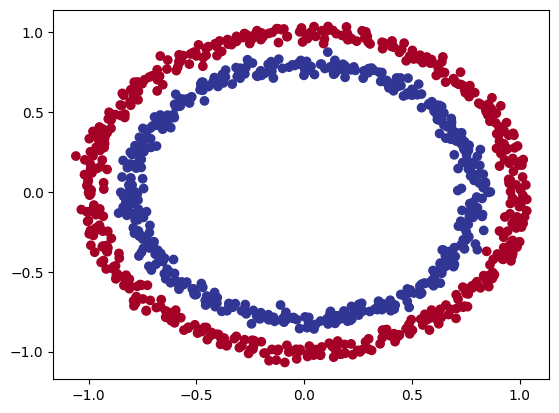

In [8]:
#Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
X_sample = X[0]
y_sample = y[0]
print(f"{X_sample}:{y_sample}")

[0.75424625 0.23148074]:1


In [11]:
### Turn data in tensors and create train and test splits
import torch
torch.__version__

'2.6.0+cu124'

In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
X.dtype

torch.float32

In [14]:
#Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

### Building a model

Lets build a model to classify our blue and red dots

To do so, we want to,
1. Setup device agonistic code so our code will run on a accelerator
2.Construct a model
3.Define a loss function and optimizer
4. Creating a training and test loop

In [16]:
import torch
from torch import nn

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
device

'cpu'

In [19]:
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

- Subclasses `nn.module` (almost all models in Pytorch subclass `nn.module`
- Create 2 `nn.linear()`
- Define `forward()` method that outlines the forward pass

In [20]:
class circle_model_v1(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = circle_model_v1().to(device)

In [21]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.1415, -0.6263],
         [-0.1113,  0.3872],
         [-0.3994,  0.2887],
         [-0.2061,  0.3372],
         [-0.1630,  0.3694]], requires_grad=True),
 Parameter containing:
 tensor([-0.1653,  0.4253,  0.3863, -0.3091,  0.4747], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3779, -0.3554, -0.4176,  0.1692, -0.3672]], requires_grad=True),
 Parameter containing:
 tensor([0.1359], requires_grad=True)]

In [22]:
model_0

circle_model_v1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)

In [24]:
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
with torch.inference_mode():
  un_trained_preds = model_0(X_test)

In [26]:
len(un_trained_preds), un_trained_preds.shape

(200, torch.Size([200, 1]))

- Regression: MSE or MAE
- Classification: cross entropy or categorical cross entropy

In [27]:
#Setup Loss function
# loss_fn = nn.BCE_Loss() requires to have gone through the sigmoid activation function prior to input to BCE Loss
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [28]:
#Calculate accuracy:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) *100
  return acc

Model outputs are going to be raw **logits**
We can convert these **logists** into prediction probabilities by passing them to some kind of activation function(Sigmoid for binary, Softmax for multiclass)

Convert models's prediction probabilites to **prediction labels** by either round them -Binary or taking argmax()- Multiclass

In [29]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test)[:5]
y_logits

tensor([[-0.1063],
        [ 0.0070],
        [-0.2597],
        [-0.0635],
        [-0.0315]])

In [30]:
# Using sigmoid activation function

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4734],
        [0.5018],
        [0.4354],
        [0.4841],
        [0.4921]])

In [31]:
y_pred = torch.round(y_pred_probs)

In [32]:
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device)[:5])))

In [33]:
print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [34]:
torch.manual_seed(42)
epochs = 300

X_train, y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):

  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # loss = loss_fn(torch.signmoid(y_logits),y_train) incase of nn.BCELoss expects predictions probabilites as input
  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true =y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred = test_pred)

  if epoch % 10 == 0:
    print(f"Epoch {epoch}| Train Loss:{loss} | Train acc:{acc:.2f}% | Test loss:{loss} | Test acc:{test_acc:.2f}%")


Epoch 0| Train Loss:0.6959547400474548 | Train acc:48.00% | Test loss:0.6959547400474548 | Test acc:49.00%
Epoch 10| Train Loss:0.6958569288253784 | Train acc:48.12% | Test loss:0.6958569288253784 | Test acc:49.00%
Epoch 20| Train Loss:0.6957643628120422 | Train acc:48.38% | Test loss:0.6957643628120422 | Test acc:49.00%
Epoch 30| Train Loss:0.6956765651702881 | Train acc:48.62% | Test loss:0.6956765651702881 | Test acc:49.00%
Epoch 40| Train Loss:0.6955931186676025 | Train acc:48.62% | Test loss:0.6955931186676025 | Test acc:49.00%
Epoch 50| Train Loss:0.695513904094696 | Train acc:49.12% | Test loss:0.695513904094696 | Test acc:49.00%
Epoch 60| Train Loss:0.6954384446144104 | Train acc:49.38% | Test loss:0.6954384446144104 | Test acc:49.00%
Epoch 70| Train Loss:0.6953665018081665 | Train acc:49.62% | Test loss:0.6953665018081665 | Test acc:49.00%
Epoch 80| Train Loss:0.6952980160713196 | Train acc:49.62% | Test loss:0.6952980160713196 | Test acc:49.50%
Epoch 90| Train Loss:0.69523262

# Make prediction and evaluvate the model
To inspect lets make visual predictions

In [35]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping downloading")
else:
  print("Download Helper function")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary

Download Helper function


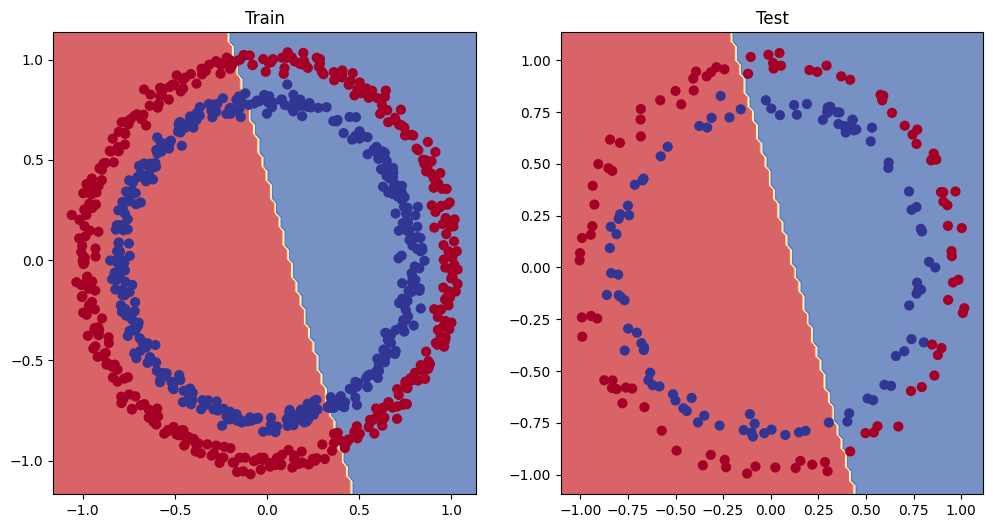

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

# Improving a model
- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for longer
- Changing the activation functions
- Change the learning rate
- Change the loss function

parameters - model updates id
hyperparameter - paramter that user can change

In [37]:
class circle_model_v2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) #Leveraging speeding

In [38]:
model_v2 = circle_model_v2().to(device)
model_v2

circle_model_v2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
#Create loss function
loss_fn1 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_v2.parameters(),lr=0.01)

In [42]:
epochs =1000

for epoch in range(epochs):
  model_v2.train()

  y_logits = model_v2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_v2.eval()
  with torch.inference_mode():
    test_logits = model_v2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}| Loss: {loss:5f}, Acc:{acc:.2f}%, Test Loss: {test_loss:5f}, Test acc: {test_acc:2f}%")

Epoch: 0| Loss: 0.693952, Acc:50.88%, Test Loss: 0.692611, Test acc: 51.000000%
Epoch: 100| Loss: 0.693688, Acc:50.25%, Test Loss: 0.692694, Test acc: 50.000000%
Epoch: 200| Loss: 0.693513, Acc:50.12%, Test Loss: 0.692818, Test acc: 49.500000%
Epoch: 300| Loss: 0.693387, Acc:50.50%, Test Loss: 0.692953, Test acc: 48.500000%
Epoch: 400| Loss: 0.693293, Acc:50.38%, Test Loss: 0.693089, Test acc: 48.500000%
Epoch: 500| Loss: 0.693222, Acc:49.88%, Test Loss: 0.693222, Test acc: 49.500000%
Epoch: 600| Loss: 0.693167, Acc:49.62%, Test Loss: 0.693349, Test acc: 53.000000%
Epoch: 700| Loss: 0.693125, Acc:49.38%, Test Loss: 0.693468, Test acc: 50.500000%
Epoch: 800| Loss: 0.693093, Acc:49.88%, Test Loss: 0.693580, Test acc: 51.000000%
Epoch: 900| Loss: 0.693068, Acc:50.50%, Test Loss: 0.693683, Test acc: 47.500000%


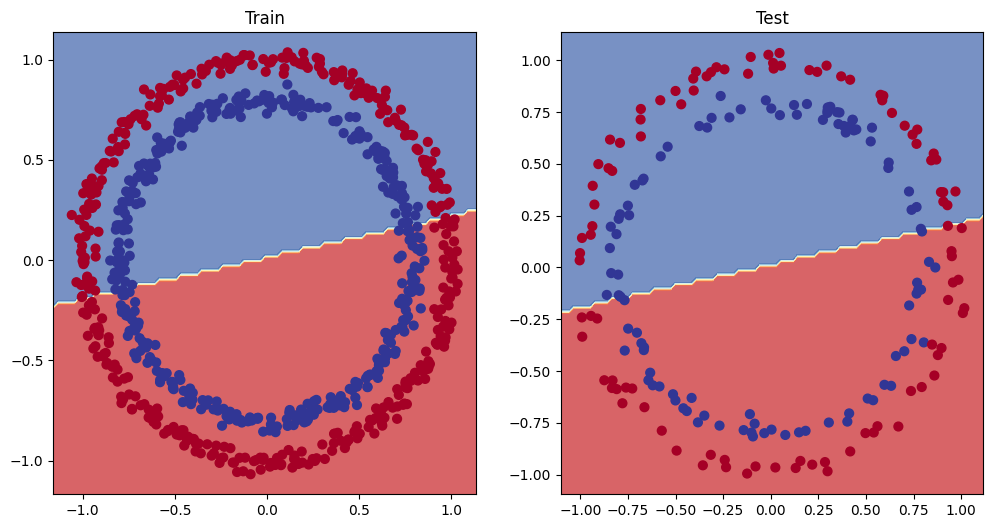

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_v2,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_v2,X_test,y_test)

## Preparding data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [44]:
weight = 0.7
bias =0.3
start = 0
end =1
step =0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [46]:
train_split = int(0.8 * len(X_regression))

X_train_regression,y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression = X_regression[train_split:],y_regression[train_split:]

In [48]:
from helper_functions import plot_predictions

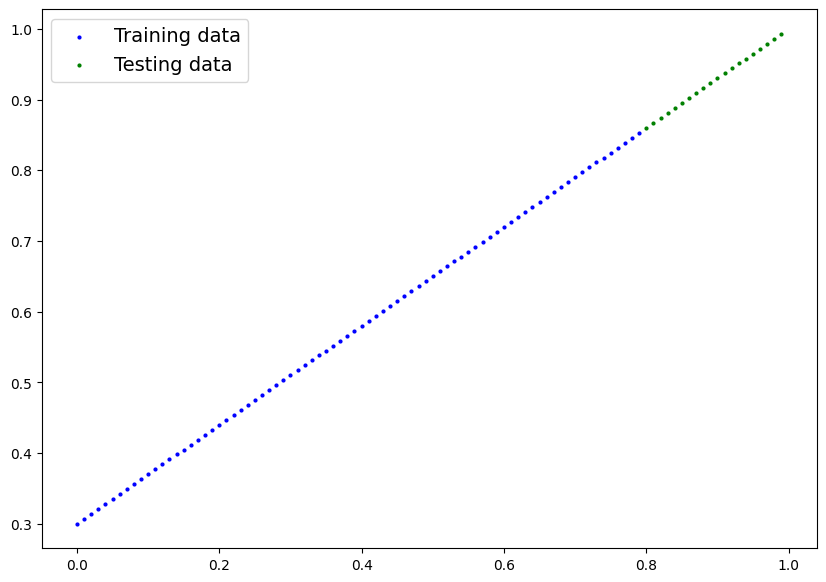

In [49]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)


In [61]:
model_v3 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
)

In [67]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_v3.parameters(),lr=0.1)

In [71]:
epochs = 2000

X_train_regression,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device),y_test_regression.to(device)

In [72]:
for epoch in range(epochs):
  model_v3.train()
  y_pred = model_v3(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_v3.eval()
  with torch.inference_mode():
    test_pred = model_v3(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  if epoch %100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.06503 | Test Loss: 0.03349
Epoch: 100 | Loss: 0.04755 | Test Loss: 0.01884
Epoch: 200 | Loss: 0.07397 | Test Loss: 0.02172
Epoch: 300 | Loss: 0.06081 | Test Loss: 0.01267
Epoch: 400 | Loss: 0.06820 | Test Loss: 0.00533
Epoch: 500 | Loss: 0.03472 | Test Loss: 0.04904
Epoch: 600 | Loss: 0.05717 | Test Loss: 0.00730
Epoch: 700 | Loss: 0.06433 | Test Loss: 0.00550
Epoch: 800 | Loss: 0.05358 | Test Loss: 0.00848
Epoch: 900 | Loss: 0.07677 | Test Loss: 0.01635
Epoch: 1000 | Loss: 0.04635 | Test Loss: 0.00653
Epoch: 1100 | Loss: 0.07553 | Test Loss: 0.00702
Epoch: 1200 | Loss: 0.07077 | Test Loss: 0.01942
Epoch: 1300 | Loss: 0.06379 | Test Loss: 0.01520
Epoch: 1400 | Loss: 0.05842 | Test Loss: 0.01242
Epoch: 1500 | Loss: 0.03822 | Test Loss: 0.03620
Epoch: 1600 | Loss: 0.06809 | Test Loss: 0.01596
Epoch: 1700 | Loss: 0.04378 | Test Loss: 0.02906
Epoch: 1800 | Loss: 0.03580 | Test Loss: 0.04225
Epoch: 1900 | Loss: 0.06488 | Test Loss: 0.03618


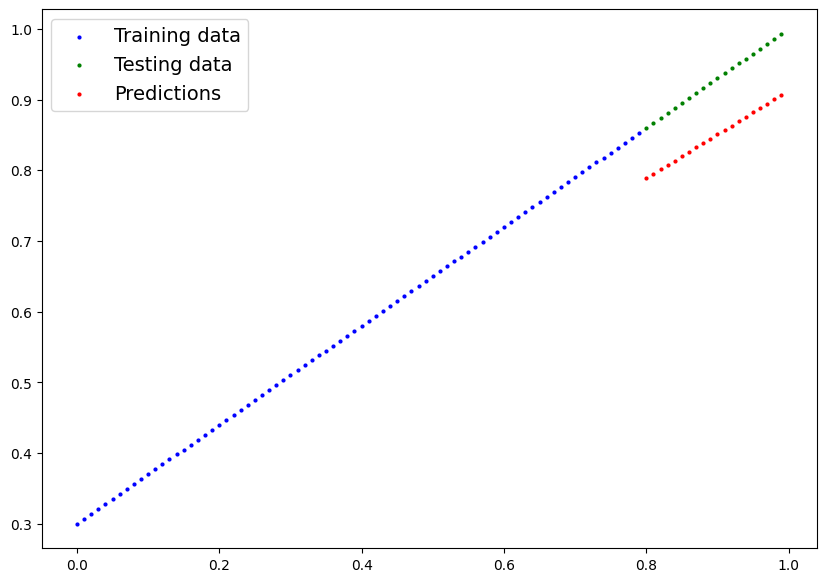

In [73]:
model_v3.eval()
with torch.inference_mode():
  preds = model_v3(X_test_regression)

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=preds)


Non Linearity

